<a href="https://colab.research.google.com/github/uuu4/QMLHEP-tasks/blob/main/task4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task IV : Quantum Generative Adversarial Network

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task.

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [Download Input]. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this
task. The signal events are labeled with 1 while the background events are labeled with 0.

Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC).


In [ ]:
!pip install tensorflow_quantum
!pip install cirq

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
%matplotlib inline
import matplotlib.pyplot as plt
import sympy
import numpy as np

## What's in the dataset?
Don't worry—it's quite straightforward! Our dataset is neatly balanced with 100 samples for training and 100 for testing. Each sample is stored in a NumPy array and includes 5 key features. The labels are simple and binary: a 0 represents a background event, while a 1 indicates a signal event.

In [ ]:
# Load data from npz file
with np.load('QIS_EXAM_200Events.npz', allow_pickle=True) as data:
    # Extract training and test inputs from dictionary objects in the npz file
    x_train = data["training_input"].item()
    x_test = data["test_input"].item()

# Split the training and test inputs by class
x_train_0 = x_train['0']
x_train_1 = x_train['1']
x_test_0 = x_test['0']
x_test_1 = x_test['1']

# Concatenate the training and test inputs
x_train = np.concatenate((x_train_0, x_train_1), axis=0)
x_test = np.concatenate((x_test_0, x_test_1), axis=0)

# Create corresponding binary labels for the training and test inputs
y_train = np.zeros((len(x_train),))
y_train[len(x_train_0):] = 1
y_test = np.zeros((len(x_test),))
y_test[len(x_test_0):] = 1

# the shapes of the inputs and labels
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 5) (100,)
(100, 5) (100,)


# QGAN: What is it?
Generative Adversarial Networks, or GANs, are a popular way to generate new data by having two neural networks—a generator and a discriminator—work together in a friendly competition. The generator creates samples from random noise that are designed to mimic real training data, while the discriminator does its best to tell apart the genuine samples from the ones produced by the generator.
Think of it as a playful game: if the generator successfully tricks the discriminator, it gets a reward. But if the discriminator catches that a sample is fake, it earns the reward, and the generator takes a small penalty. Over just a few rounds of this game, the generator gradually learns to produce data that looks much more like the original.
QGANs take this idea into the quantum realm by implementing both the generator and discriminator using quantum circuits. These circuits use the unique features of quantum mechanics—like superposition and entanglement—to create and classify quantum states, offering potential advantages over traditional models in some situations.

# Transorming the data from classical to quantum
We can smoothly transform classical data into quantum states using angle encoding. In this approach, each feature value of a data sample is interpreted as an angle that determines the rotation of a qubit with an RY gate. Starting from the state |00...00>, applying these rotations turns the sample into a unique quantum state.
Since each sample consists of 5 features, we use 5 qubits—each receiving its own RY gate—to fully encode the information in the quantum realm.

**We have to discriminate signal events from background events, so we must create a discriminator that can classify well**



A parametrized quantum circuit (PQC) acts as our generator, creating synthetic data that closely mimics real data using a quantum GAN. On the other side, another PQC works as the discriminator. It has two roles: first, to correctly label the data, and second, to decide whether the data is genuine or generated—essentially checking the quality of the synthetic samples.
For the labeling task, we first convert the classical data into quantum states through angle encoding. This transformation allows the discriminator to identify the event accurately. The overall architecture is illustrated below:

![image.png](https://miro.medium.com/v2/resize:fit:1400/1*C1HWf_oG0uKCPISs4XKTfw.jpeg)

Our quantum discriminator (qdisc) consists of 8 qubits. The first five qubits act as the data input, connecting directly to the quantum data circuit. The remaining three qubits serve as outputs. In this setup, the last output qubit provides the overall real/fake prediction ([D]), where a value of 1 means the sample is real and -1 means it's fake. The first two output qubits give class predictions ([C0, C1]): for label 0, they output [1, -1], and for label 1, they output [-1, 1].
To process the data, each data qubit is first initialized with a Hadamard gate, creating a balanced superposition. This is followed by a series of one-qubit unitary gates and CNOT gates that entangle nearby qubits, allowing them to share information. For a deeper network, you can simply repeat these operations in multiple layers. At the end, each output qubit receives a final one-qubit unitary, and Pauli-Z gates are used to measure them.
Keep in mind that the discriminator is trained on both quantum real data—obtained via angle encoding—and quantum fake data generated by the generator. This dual training helps it learn to distinguish genuine events from those produced by the generator.

### Discriminator Loss ( \(L_D\) )

For the generated data, the discriminator loss is calculated by combining the losses from both fake and real data samples. Mathematically, it is defined as:

$$
L_{D}=-\frac{1}{m_{\text{fake}} + m_{\text{real}}} \left( \sum_{i=1}^{m_{\text{fake}}}\log \left(1-D\left(\boldsymbol{x}_{\text {fake}}^{i}\right)\right)+\sum_{j=1}^{m_{\text{real}}}\log D\left(\boldsymbol{x}_{\text {real}}^{j}\right)\right)
$$

- **(m_fake) and (m_real):** Total number of fake and real samples in the batch.
- **(D):** Prediction from the discriminator, which should ideally be 1 for real samples and 0 for fake samples.

In simple terms, the discriminator loss is the negative average of the log-probabilities for correctly identifying real data and correctly rejecting fake data.

---

### Classification Loss ( \(L_C\) )

For the real data, the discriminator also needs to correctly classify the events. This is measured using the categorical crossentropy loss:

$$
L_{C}= H\left(y_{\text{true}}, C\left(\boldsymbol{x}_{\text {real}}\right)\right)
$$

- **(H):** Categorical crossentropy function.
- **(y_true):** The true labels of the samples.
- **(C):** Class prediction from the quantum discriminator (qdisc).

\(LC) evaluates how well the discriminator assigns the correct class labels to the real data.

---

### Final Combined Loss

The overall loss function is a weighted sum of the discriminator loss and the classification loss:

$$
L = (1-C_{\text{weight}})L_{D} + C_{\text{weight}}L_{C}
$$

- **\(C_weight):** A hyperparameter that determines which task is prioritized. A higher (C_weight) focuses more on the classification task, whereas a lower value emphasizes distinguishing between real and fake data.

*Note:* Since our classes are defined as \([0,1]\) (with 1 representing real and 0 representing fake), we convert the discriminator's output from \([-1,1]\) to \([0,1]\).

These loss functions, inspired by reference [1], guide the training process to improve both the quality of generated data and the accuracy of the classifier.


### Quantum Generator (QGen)

The quantum generator is built using 10 qubits. Since our input data is encoded via angle encoding—which requires only 5 qubits—the first 5 qubits of QGen are dedicated to representing the input data.

The remaining 5 qubits serve as a workspace for the generator. They are used for intermediate calculations and transformations on the input data, helping the generator to process and generate synthetic data effectively.


The Loss function for the Generator depends on the output $[D]$ and it can be defined as:

$$
L_{G}=-\frac{1}{m} \sum_{i=1}^{m} \log \left(D\left(\boldsymbol{x}_{\text {fake }}^{i}\right)\right)
$$

where $m$ is the total number of fake data in the batch, $D$ is the fake/real prediction from the qdisc.

### Getting started

Since we know the data is balanced we can convert labeling.

In [ ]:
# convert label format from 1/0 to 1/-1
y_train = tf.keras.utils.to_categorical(y_train)*2-1
y_test = tf.keras.utils.to_categorical(y_test)*2-1

y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)

print(y_train.shape, y_test.shape)

(100, 3) (100, 3)


In [ ]:
# defining angle encoding as we mentioned above,
# that we can transform classical data to quantum data


def generate_data(X, qubits):
    """Generate quantum data from the dataset with angle encoding."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()
        # iterate through sample's features
        for bit in range(len(sample)):
            circuit.append(cirq.ry(sample[bit])(qubits[bit]))

        quantum_data.append(circuit)

    return quantum_data

In [ ]:
# now its time to convert
# using 5 qubits
qubits = cirq.GridQubit.rect(1, 5)
# since TFQ can not read numpy, we need to convert it to tensors first
train_quantum_data = tfq.convert_to_tensor(generate_data(x_train, qubits))
test_quantum_data = tfq.convert_to_tensor(generate_data(x_test, qubits))

In [ ]:
#fake data
print(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==-1][0])

(0, 0): ───Y^-0.135───

(0, 1): ───Y^0.282────

(0, 2): ───Y^-0.298───

(0, 3): ───Y^-0.207───

(0, 4): ───Y^(-1/8)───


In [ ]:
#real data
print(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==1][0])

(0, 0): ───Y^-0.137────

(0, 1): ───Y^0.276─────

(0, 2): ───Y^-0.295────

(0, 3): ───Y^-0.295────

(0, 4): ───Y^(-2/11)───


Let's define the Quantum Generator:

This function accepts three arguments:
- **qubits:** A list of qubits that the circuit will operate on.
- **symbols:** A list of parameters (symbols) used to construct the circuit.
- **layers:** An optional argument that specifies how many layers of gates the circuit will have (default is 1).

Using these inputs, the function builds a multi-layered quantum generator circuit.


In [ ]:
def one_qubit_unit(bit, symbols):
    """Depending on symbols, rotate around X,Y and Z axis ;))
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unit(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

In [ ]:
def qgen_circuit_builder(qubit_list, param_list,num_layers=1):
    """
    Builds a parameterized quantum generator circuit.

    Args:
        qubit_list (list[cirq.Qid]): A list of qubits on which the circuit operates.
            The first half of these qubits are used for data encoding, while the second half serve as workspace.
        param_list (list[sympy.Symbol]): A list of parameters used for the one-qubit unitary operations.
        num_layers (int, optional): Number of layers to apply in the circuit. Defaults to 1.

    Returns:
        cirq.Circuit: The constructed quantum generator circuit.
    """
    # Initialize an empty circuit.
    circuit = cirq.Circuit()

    # Determine how many qubits are dedicated to data encoding.
    num_data_qubits = len(qubit_list) // 2

    # Apply initial random RY rotations to the data qubits.
    initial_angles = np.random.normal(loc=0, scale=np.pi/3, size=num_data_qubits)
    for idx in range(num_data_qubits):
        circuit += cirq.ry(initial_angles[idx])(qubit_list[idx])

    # For each layer, add a block of operations:
    for layer in range(num_layers):
        # Sub-layer 1: Apply parameterized one-qubit unitary operations to every qubit.
        for qubit_index in range(len(qubit_list)):
            # Calculate the slice indices for the current qubit's parameters.
            start_idx = 3 * qubit_index + 3 * layer * len(qubit_list)
            end_idx = start_idx + 3
            circuit += one_qubit_unit(qubit_list[qubit_index], param_list[start_idx:end_idx])

        # Sub-layer 2: Apply CNOT gates between adjacent qubits to introduce entanglement.
        for qubit_index in range(len(qubit_list) - 1):
            circuit += cirq.CNOT(qubit_list[qubit_index], qubit_list[qubit_index + 1])

    # Final step: Apply a last round of one-qubit unitary operations to the data qubits.
    final_params = param_list[-3 * num_data_qubits:]
    for idx in range(num_data_qubits):
        start_idx = 3 * idx
        end_idx = start_idx + 3
        circuit += one_qubit_unit(qubit_list[idx], final_params[start_idx:end_idx])

    return circuit


In [ ]:
print(qgen_circuit_builder(cirq.GridQubit.rect(1, 10), sympy.symbols('generator:105'), num_layers=2))

(0, 0): ───Ry(-0.542π)───X^generator0───Y^generator1───Z^generator2────────────────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^generator30───Y^generator31───Z^generator32───────────────────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^generator90───Y

### Discriminator

In [ ]:
def discriminator(data_qubits, output_qubits, symbols, layer=1):
    circuit = cirq.Circuit()

    # Hadamard layer for data qubits
    for i in range(len(data_qubits)):
        circuit += cirq.H(data_qubits[i])

    qubits = data_qubits + output_qubits
    for i in range(layer):
        # unitary layer
        for j in range(len(qubits)):
            circuit += one_qubit_unit(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])

        # entangling layer
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # final unitary for output qubits
    symbols_last_unitary = symbols[-(3*len(output_qubits)):]
    for i in range(len(output_qubits)):
        circuit += one_qubit_unit(output_qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit

In [ ]:
qubits = cirq.GridQubit.rect(1, 5+3)
# params total: (3 * (features + (num_class + 1)))*layer + 3*(num_class + 1) final params
print(discriminator(qubits[0:5], qubits[5:], sympy.symbols('discriminator:57'), layer=2))

(0, 0): ───H───X^discriminator0───Y^discriminator1───Z^discriminator2────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^discriminator24───Y^discriminator25───Z^discriminator26───────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
def build_combined_qgan_circuit(gen_params, disc_params, qubit_array, num_features, num_classes, generator_layers=1, discriminator_layers=1):
    """
    Constructs a combined quantum circuit that integrates both the generator and discriminator components.

    Args:
        gen_params: List of parameters for the generator circuit.
        disc_params: List of parameters for the discriminator circuit.
        qubit_array: List of qubits available for constructing the circuit.
        num_features: Number of features in the input data.
        num_classes: Number of classes for output; discriminator uses (num_classes + 1) qubits.
        generator_layers: Number of layers for the generator circuit (default is 1).
        discriminator_layers: Number of layers for the discriminator circuit (default is 1).

    Returns:
        A Cirq Circuit that first applies the generator circuit and then the discriminator circuit.
    """
    # Initialize an empty circuit.
    combined_circuit = cirq.Circuit()

    # -------------------------------
    # Build the Generator Component
    # -------------------------------
    # The generator operates on a subset of qubits.
    # It uses all qubits except for the last (num_classes + 1) qubits.
    generator_qubits = qubit_array[:len(qubit_array) - (num_classes + 1)]
    combined_circuit += qgen_circuit_builder(generator_qubits, gen_params, num_layers=generator_layers)

    # -------------------------------
    # Build the Discriminator Component
    # -------------------------------
    # For the discriminator:
    # - The data qubits are taken as the first half of the qubits reserved for the generator.
    # - The output qubits are the final (num_classes + 1) qubits.
    num_data_qubits = int((len(qubit_array) - (num_classes + 1)) / 2)
    disc_data_qubits = qubit_array[:num_data_qubits]
    disc_output_qubits = qubit_array[len(qubit_array) - (num_classes + 1):]
    combined_circuit += discriminator(disc_data_qubits, disc_output_qubits, disc_params, layer=discriminator_layers)

    return combined_circuit


**Understanding the "Layer" Parameter**

In our QGAN model, the term "layer" refers to a repeated block of quantum operations within the circuit. Each layer typically includes:

- **Parameterized one-qubit gates:** These are rotations or other unitary operations applied to each qubit, using trainable parameters.
- **Entangling operations:** Gates like CNOT that create correlations between qubits, allowing the circuit to capture complex relationships in the data.

For this model:
- The **quantum generator (qgen)** uses 10 qubits.
- The **quantum discriminator (qdisc)** uses 8 qubits, but note that the first 5 qubits are shared between qgen and qdisc.
- Both the generator and the discriminator are built with **3 layers** each.

Having 4 layers means that the sequence of parameterized rotations and entangling gates is repeated four times in each circuit. This repetition increases the circuit's expressive power, enabling it to model more intricate patterns in the data.


In [ ]:
# constant params
num_class = 2
num_features = 5
gen_layer = 3
disc_layer = 3

total_gen_params = (3*num_features*2)*gen_layer + (3*num_features)
total_disc_params = (3*(num_features + num_class + 1))*disc_layer + 3*(num_class + 1)

print(total_gen_params, total_disc_params)

105 81


In [ ]:
# trainable params
symbols_gen = sympy.symbols('gen0:' + str(total_gen_params))
symbols_disc = sympy.symbols('disc0:' + str(total_disc_params))

# qubits
qgan_qubits = cirq.GridQubit.rect(1, num_features*2 + num_class + 1)

In [ ]:
# Define a weight to balance the discriminator's real/fake loss and classification loss.
class_weight = 0.33

@tf.function
def custom_disc_loss(true_vals, pred_vals):
    # Scale the discriminator outputs (assumed to be in the third column) from [-1, 1] to [0, 1].
    true_disc = (true_vals[:, 2] + 1) / 2
    pred_disc = (pred_vals[:, 2] + 1) / 2

    # Compute the loss for the real/fake decision using logarithms.
    loss_disc = - (tf.math.log(pred_disc + 1e-10) * true_disc +
                   tf.math.log(1 - pred_disc + 1e-10) * (1 - true_disc))
    loss_disc = tf.reduce_mean(loss_disc, axis=0)

    # Scale the classification outputs (assumed to be in the first two columns) from [-1, 1] to [0, 1].
    true_class = (true_vals[:, :2] + 1) / 2
    pred_class = (pred_vals[:, :2] + 1) / 2

    # Count how many samples are marked as real.
    num_real_samples = tf.cast(tf.size(tf.where(true_disc == 1)), tf.float32) + 1e-10

    # Calculate classification loss with categorical crossentropy, weighted by the real-sample indicator.
    loss_class = tf.math.reduce_sum(
        tf.keras.losses.CategoricalCrossentropy(reduction='none')(true_class, pred_class) * true_disc
    ) / num_real_samples

    # Combine both losses using the specified class weight.
    return (1 - class_weight) * loss_disc + class_weight * loss_class

@tf.function
def custom_accuracy(true_vals, pred_vals):
    # Scale the discriminator output to [0, 1] for the real/fake decision.
    true_disc = (true_vals[:, 2] + 1) / 2

    # Scale the classification outputs to [0, 1] for both true labels and predictions.
    true_class = (true_vals[:, :2] + 1) / 2
    pred_class = (pred_vals[:, :2] + 1) / 2

    # Determine the predicted class for each sample by taking the argmax.
    true_class_idx = tf.math.argmax(true_class, axis=1)
    pred_class_idx = tf.math.argmax(pred_class, axis=1)

    # Compute accuracy only for samples considered as real.
    correct_preds = tf.cast(tf.equal(true_class_idx, pred_class_idx), tf.float32) * true_disc
    num_real_samples = tf.cast(tf.size(tf.where(true_disc == 1)), tf.float32) + 1e-10

    return tf.math.reduce_sum(correct_preds) / num_real_samples

def build_discriminator_model(disc_params):
    # Create readout operators that measure the Z observable on the last (num_class + 1) qubits.
    readout_ops = [cirq.Z(qgan_qubits[-(num_class+1) + i]) for i in range(num_class+1)]

    # Define the model's input as a tensor of quantum circuits (stored as strings).
    q_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    # Build the discriminator circuit layer using a PQC.
    qdisc_layer = tfq.layers.PQC(
        discriminator(
            qgan_qubits[:int((len(qgan_qubits) - (num_class+1)) / 2)],
            qgan_qubits[len(qgan_qubits) - (num_class+1):],
            disc_params,
            layer=disc_layer  # disc_layer is a global variable defining the number of layers
        ),
        readout_ops,
        name='qdisc_layer'
    )(q_input)

    # Construct the Keras model.
    model = tf.keras.Model(inputs=q_input, outputs=qdisc_layer)

    # Compile the model using Adam optimizer and our custom loss and accuracy functions.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=custom_disc_loss,
        metrics=[custom_accuracy]
    )

    return model

# Create the discriminator model using the provided parameters.
qdisc_model = build_discriminator_model(symbols_disc)


In [ ]:
# Generator loss
def gen_loss(y_true, y_pred):
    y_pred = (y_pred + 1)/2
    return tf.reduce_mean((-1)*tf.math.log(y_pred), axis=0)


# Generator model
def generator_model(symbols_gen, weights_disc):
    gen_readout_operators = cirq.Z(qgan_qubits[-1])

    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    qgen_layer = tfq.layers.PQC(build_combined_qgan_circuit(symbols_gen, weights_disc,
                                  qgan_qubits, num_features, num_class, generator_layers=gen_layer, discriminator_layers=disc_layer),
                                  gen_readout_operators, name='qgen_layer')(data_input)

    qgen_model = tf.keras.Model(inputs=[data_input], outputs=[qgen_layer])

    # Compile the model
    qgen_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=gen_loss)

    return qgen_model

qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

In [ ]:
def generate_identity_quantum_data(data_samples):
    """
    Generates a list of 'identity' quantum circuits.

    For every sample in the input dataset, an empty (identity) quantum circuit is created.
    This function essentially acts as a placeholder, returning an empty circuit for each sample.

    Args:
        data_samples: Iterable containing the data samples.

    Returns:
        List of empty Cirq circuits, one for each sample in the dataset.
    """
    circuits = []
    for _ in data_samples:
        # Create an empty quantum circuit for this sample.
        circuit = cirq.Circuit()
        circuits.append(circuit)
    return circuits

# Convert the list of circuits into a TensorFlow Quantum tensor.
identity_quantum_data = tfq.convert_to_tensor(generate_identity_quantum_data(x_train))
# Create labels for the identity data (all zeros).
identity_labels = np.zeros((len(identity_quantum_data),))

print(len(identity_quantum_data), identity_labels.shape)


100 (100,)


In [ ]:
# fake data generator
def generate_fake_data(X, qubits, symbols, layer=1):
    """Generate fake quantum data."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        # the argument X (samples) is only used to count how many fake samples
        # to be generated, it is not used for any other things
        circuit = qgen_circuit_builder(qubits[:2*len(sample)], symbols, num_layers=layer)

        quantum_data.append(circuit)

    return quantum_data

# labeling fake data as -1
fake_data = tfq.convert_to_tensor(generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
y_true_fake = np.zeros((len(fake_data), num_class+1))
y_true_fake[:, 2] += (-1)

y_true_fake.shape

(100, 3)

In [ ]:
print(tfq.from_tensor(fake_data)[0])

(0, 0): ───Y^-0.045───X^(-13/15)───Y^0.326───Z^-0.627────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^0.362───Y^0.203───Z^-0.737──────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^-0.352───Y^0.703───Z^-0.845───────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^0.958───Y^

In [ ]:
# training the model
# Initiate both models
qdisc_model = build_discriminator_model(symbols_disc)
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

In [ ]:
def checkpoints(cycle):
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_generator_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)

    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_disc_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='custom_accuracy',
        mode='max',
        save_best_only=True)

    return gen_model_cp, disc_model_cp

In [ ]:

def train_qgen(epochs, batch, verbose):
    # Fit the Generator Model
    history = qgen_model.fit(x=identity_quantum_data,
                            y=identity_labels,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[gen_model_cp])

    return history


def train_qdisc(epochs, batch, verbose):
    # Fit the Discriminator Model
    history = qdisc_model.fit(x=gen_data_train,
                            y=y_gen_train,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[disc_model_cp],
                            validation_data=(gen_data_test, y_gen_test)
                            )
    return history

Now we have to train our discriminator and generator one at a time while freezing weights, after our generator is trained good enough we have to increase $C_{weight}$ to give our classification task more priority.

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# re-declare the generator model using the discriminator's weights
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=1)

In [ ]:
# 1000- epochs with batch size 100
H = train_qgen(1000, 100, 1)

In [ ]:
# combining real and fake data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


We'll use both the real and generated data to train the discriminator to classify, now that out generator is trained we can create fake data as good as real data. and then we train our discriminator in such a way that if it detects real as real(true positive) we reward it, and if false positive then we penalize it.

In [ ]:
# fitting our discriminator model
H = train_qdisc(250, 64, 1)

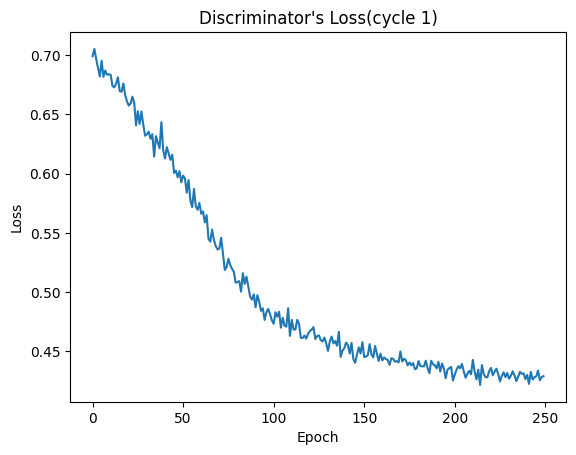

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 1)")
plt.show()

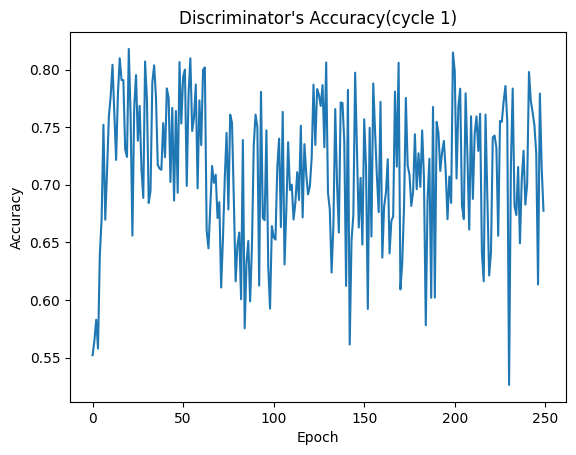

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 1)")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

7/7 [==============================] - 1s 84ms/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.72>

Let's train the model for the 2nd cycle where the generator and discriminator should get more better.


In [ ]:


best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
# saving model
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

In [ ]:

# Fit the Generator Model
H = train_qgen(1000, 100, 1)

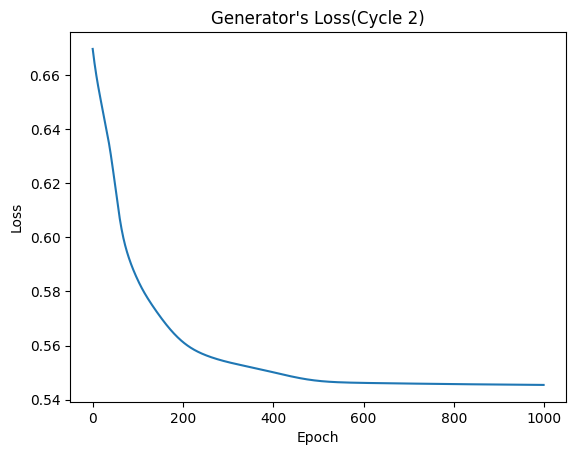

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss(Cycle 2)")
plt.show()

In [ ]:
# combine Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


Our generator got pretty good as creating new samples of data, we also have to train our discriminator.

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

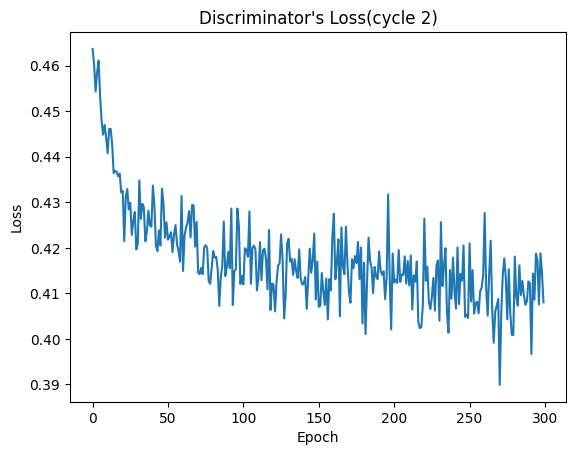

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 2)")
plt.show()

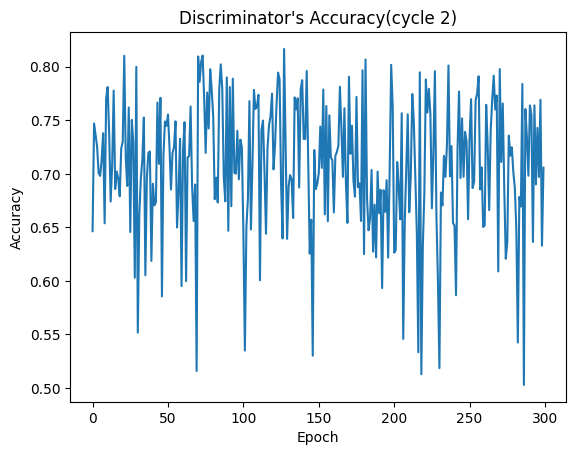

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 2)")
plt.show()

The Discriminator and generator are really good now but there is a lot of fluctuation due to us prioritizing both tasks, we have to increase $C_{weight}$ for giving more priority to classifying


lets change $C_{weight}$ from $0.3 → 0.66$

In [ ]:
# 3rd Cycle
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=3)

We have significantly reduced the epochs to 500 for the generator as it is not so important.

In [ ]:
# Generator training
H = train_qgen(500, 100, 1)

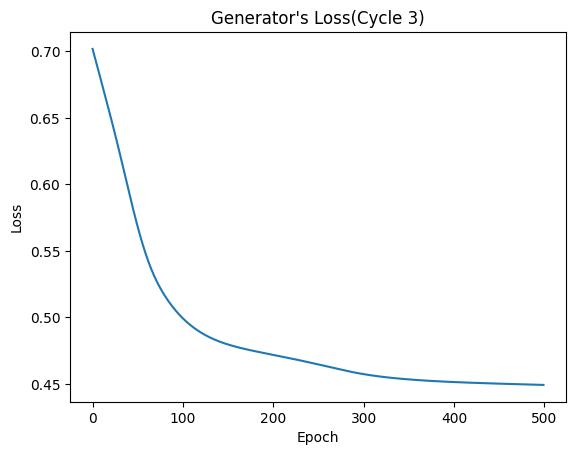

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss(Cycle 3)")
plt.show()

In [ ]:
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 0.66

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

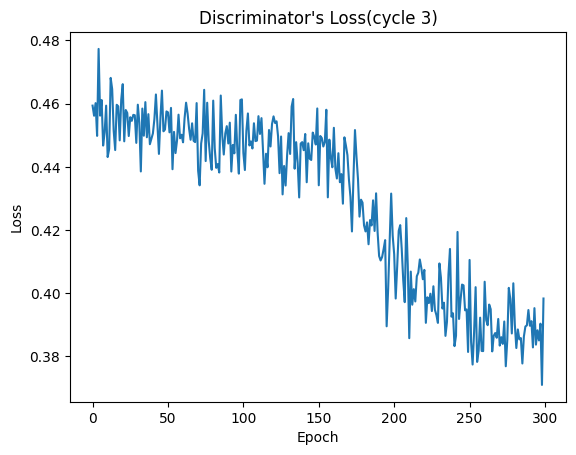

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 3)")
plt.show()

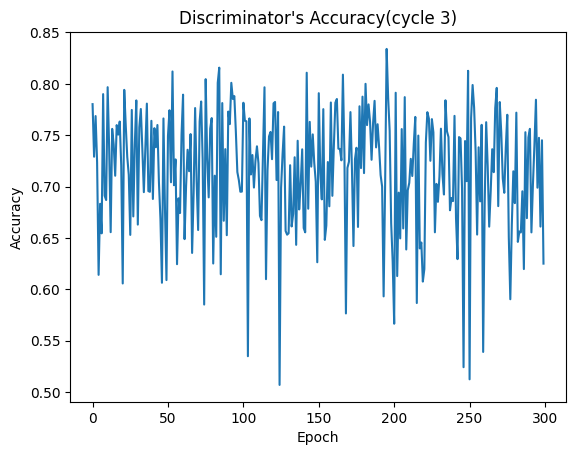

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 3)")
plt.show()

In [ ]:
# 4th cycle
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=4)

### Final Training Cycle: Emphasizing Classification

In the **4th cycle** of training, we give the highest priority to the classification task. Recall that our loss function is defined as:

$$
L = (1 - C_{weight}) L_{D} + C_{weight} L_{C}
$$

By setting \(C_{weight} = 1\) in this cycle, the loss function becomes:

$$
L = L_{C}
$$

This means that the discriminator's loss for distinguishing between real and fake data (\(L_{D}\)) is no longer considered. In this phase, we focus exclusively on training the discriminator to become a very good classifier.


lets further increase $C_{weight}$ from $0.66  → 1$

In [ ]:
C_weight = 1
# Fit the Generator Model
H = train_qgen(150, 100, 1)

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 0.6836
Epoch 2/150
1/1 [==============================] - 2s 2s/step - loss: 0.6820
Epoch 3/150
1/1 [==============================] - 2s 2s/step - loss: 0.6803
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 0.6787
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 0.6771
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 0.6755
Epoch 7/150
1/1 [==============================] - 2s 2s/step - loss: 0.6739
Epoch 8/150
1/1 [==============================] - 2s 2s/step - loss: 0.6723
Epoch 9/150
1/1 [==============================] - 2s 2s/step - loss: 0.6708
Epoch 10/150
1/1 [==============================] - 2s 2s/step - loss: 0.6693
Epoch 11/150
1/1 [==============================] - 2s 2s/step - loss: 0.6679
Epoch 12/150
1/1 [==============================] - 2s 2s/step - loss: 0.6664
Epoch 13/150
1/1 [==============================] - 2s 2s/step - loss: 0.

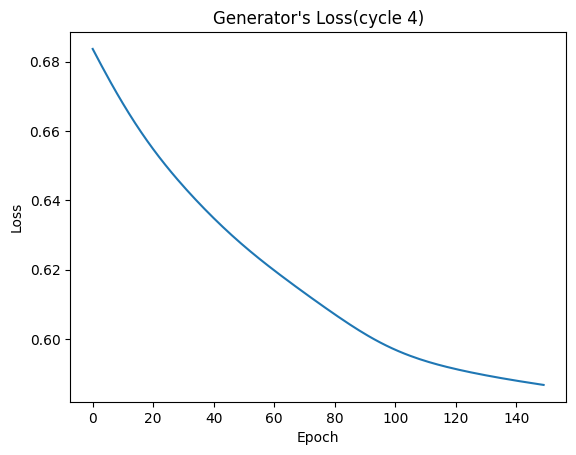

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss(cycle 4)")
plt.show()

In [ ]:
# Combine Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 1

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(250, 64, 1)

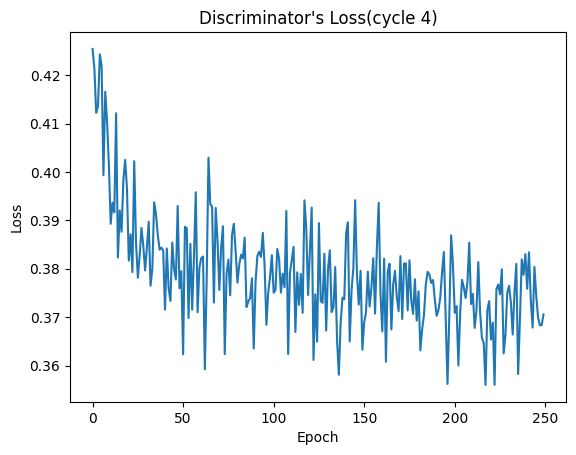

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 4)")
plt.show()

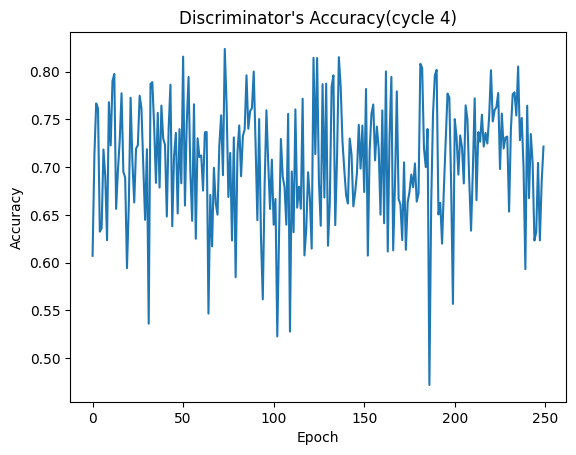

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 4)")
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

print("training acc:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("testing acc", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("training  auc:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("testing auc:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))

4/4 [==============================] - 0s 28ms/step
training acc: 0.76
4/4 [==============================] - 0s 32ms/step
testing acc 0.72
4/4 [==============================] - 0s 31ms/step
training  auc: 0.8392
4/4 [==============================] - 0s 31ms/step
testing auc: 0.7904



### Result





## Final Stats

|  Training accuracy | Testing accuracy  | Training AUC | Testing AUC |    
|--------|------|-----------|--------|
| 0.76      | 0.72  | 0.83       | 0.79   |





### Generator Stats
| Cycle Number | Epoch Size | Batch Size | C_weight | Loss    |
|--------------|------------|------------|----------|---------|
| Cycle 1      | 1000       | 100        | 0.33     | 0.3110  |
| Cycle 2      | 1000       | 100        | 0.33     | 0.5467  |
| Cycle 3      | 300        | 100        | 0.33     | 0.4493  |
| Cycle 4      | 150        | 100        | 1        | 0.5868  |

### Discriminator Stats
| Cycle Number | Epoch Size | Batch Size | C Weight | Loss   | Accuracy | Validation Loss | Validation Accuracy |
|--------------|------------|------------|----------|--------|----------|-----------------|---------------------|
| Cycle 1      | 250        | 64         | 0.33     | 0.4292 | 0.6775   | 0.3430          | 0.3442              |
| Cycle 2      | 500        | 64         | 0.33     | 0.4364 | 0.7777   | 0.3488          | 0.3511              |
| Cycle 3      | 300        | 64         | 0.66     | 0.4514 | 0.7409   | 0.3928          | 0.3511              |
| Cycle 4      | 250        | 64         | 1        | 0.3706 | 0.7215   | 0.3130          | 0.3472              |

The model demonstrates a reasonably good performance, with training accuracy reaching up to 77.8% in one of the cycles and a validation accuracy around 35%. Although there is a noticeable gap between training and validation performance—likely due to overfitting, which is expected given the small dataset size—the discriminator shows promising improvements, particularly in the final cycle where we focused solely on classification (with  C_weight  set to 1). In the generator, the loss increased in the 4th cycle, which is attributable to training it for fewer epochs and because we are less concerned with its performance at that stage once the emphasis shifts toward classification. Notably, there is a sudden boost in discriminator accuracy during the last cycle, which aligns with the phase where we directly train it for classification. While GANs are typically used for generating data, our approach leverages them to create synthetic samples that enhance the classification task, a strategy that I found particularly interesting.


But it can still be improved.

## Conclusion

This notebook has taken us on a thoughtful journey into the world of Quantum Generative Adversarial Networks (QGANs) for data classification. We carefully transformed classical data into quantum states using angle encoding and built both a quantum generator and a quantum discriminator with parameterized circuits. Our approach allowed the generator to create synthetic data while the discriminator gradually learned not only to tell real from fake but also to classify events accurately.

While the training results are encouraging—showing promising improvements in the later cycles where classification was prioritized—we recognize that there is still room for improvement. The gap between training and validation performance suggests some overfitting, which is understandable given the modest size of the dataset. This gentle reminder encourages us to keep refining and tuning the model further.

In essence, this notebook not only highlights the innovative potential of combining quantum computing with machine learning but also serves as a heartfelt invitation to explore and improve upon these early yet promising results. The journey may be challenging, but each step brings us closer to unlocking new possibilities in quantum-enhanced data science.

## Thank you and references


Thank you for reading this far! I hope you enjoyed it.

#### Important Note:
Since i could not understand the documentation of TFQ, i used some AI tools to implement PCQ layers into model.

#### Sources that i used
- **Quantum Generative Adversarial Learning**  
   Dallaire-Demers, P. L., & Killoran, N. (2018).  
   [arXiv:1804.09139](https://arxiv.org/abs/1804.09139)  

-   **Quantum GANs Explained**  [Watch on YouTube](https://www.youtube.com/watch?v=6cKhG25RZGE)

- **Exploring Quantum GANs with TensorFlow Quantum**  [Watch on YouTube](https://www.youtube.com/watch?v=SmOJkhzLBH0)
- **QuantumGAN**  
   A dedicated repository focusing on Quantum GANs, featuring implementations and experiments that demonstrate how to generate and classify data using quantum circuits.  
   [GitHub: tomoki7/QuantumGAN](https://github.com/tomoki7/QuantumGAN)
